# Bank Marketing Campaign Classification

This notebook builds a classification pipeline to predict whether a customer will subscribe to a term deposit based on the UCI Bank Marketing dataset.

## Imports

In [1]:
# Standard library
from pathlib import Path
import warnings

# Data manipulation
import pandas as pd
import numpy as np

# Scikit-learn: preprocessing and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model interpretability
import shap

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

Configure project paths and load the Bank Marketing dataset.

In [2]:
# Resolve project paths
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

# Define directory structure
DATA_DIR = PROJECT_ROOT / "datasets" / "bank-marketing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"

# Create output directories
for path in [PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")

Project root: /home/ermaolaoye/data-mining
Outputs directory: /home/ermaolaoye/data-mining/outputs


In [3]:
# Load dataset
data_path = DATA_DIR / "bank-full.csv"
df_raw = pd.read_csv(data_path, sep=";")

print(f"Loaded {df_raw.shape[0]:,} rows and {df_raw.shape[1]} columns")
print(f"\nTarget distribution:")
print(df_raw["y"].value_counts(normalize=True).rename("proportion").to_string())
print(f"\nClass imbalance ratio: {df_raw['y'].value_counts()['no'] / df_raw['y'].value_counts()['yes']:.2f}:1")

Loaded 45,211 rows and 17 columns

Target distribution:
y
no     0.883015
yes    0.116985

Class imbalance ratio: 7.55:1


## Preprocessing

### Outlier Removal
Remove extreme outliers (z-score > 3) from numeric columns to reduce noise.

In [4]:
# Remove outliers using z-score method
# Keeps more edge cases that may contain valuable signal
df = df_raw.copy()
outlier_cols = ["balance", "age", "campaign"]

# Drop duration column - it's only known after a call ends (data leakage)
df = df.drop(columns=["duration"])

# Create a combined mask for all outlier conditions (relaxed threshold)
outlier_mask = pd.Series(True, index=df.index)
for col in outlier_cols:
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    outlier_mask &= (z_scores < 4)  # Changed from 3 to 4 (less aggressive)

df = df[outlier_mask].reset_index(drop=True)

print(f"Rows before: {df_raw.shape[0]:,}")
print(f"Rows after outlier removal: {df.shape[0]:,}")
print(f"Rows removed: {df_raw.shape[0] - df.shape[0]:,} ({100 * (1 - df.shape[0] / df_raw.shape[0]):.1f}%)")
print(f"\nNote: 'duration' column dropped (only known post-call, causes data leakage)")

Rows before: 45,211
Rows after outlier removal: 44,220
Rows removed: 991 (2.2%)

Note: 'duration' column dropped (only known post-call, causes data leakage)


In [5]:
# Separate features and target
X = df.drop(columns="y")
y = df["y"].map({"yes": 1, "no": 0})

# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric features (6): ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']


## Feature Engineering

Create domain-specific features to improve model predictive power.

**Note**: The `duration` feature was removed from the dataset as it represents call duration, which is only known after a call ends and would cause data leakage in a real prediction scenario.

In [6]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # -1 means never contacted, don't use 999 which creates outliers
    df["was_contacted_before"] = (df["pdays"] != -1).astype(int)
    
    # For those contacted before, use log transform (adds 1 to avoid log(0))
    # For never contacted, use median of contacted group
    contacted_mask = df["pdays"] != -1
    if contacted_mask.sum() > 0:
        median_pdays = df.loc[contacted_mask, "pdays"].median()
        df["pdays_transformed"] = df["pdays"].replace(-1, median_pdays)
        df["pdays_log"] = np.log1p(df["pdays_transformed"])
    else:
        df["pdays_log"] = 0
    
    # Recency buckets, more informative than raw days
    df["contact_recency"] = pd.cut(
        df["pdays"].replace(-1, 9999),
        bins=[-1, 7, 30, 90, 180, 365, 10000],
        labels=["week", "month", "quarter", "half_year", "year", "never"]
    ).astype(str)
    
    # Previous campaign success is extremely predictive (~65% conversion if success)
    df["prev_success"] = (df["poutcome"] == "success").astype(int)
    df["prev_failure"] = (df["poutcome"] == "failure").astype(int)
    df["prev_unknown"] = (df["poutcome"] == "unknown").astype(int)
    
    # Interaction: contacted before AND had success
    df["contacted_and_success"] = (df["was_contacted_before"] & df["prev_success"]).astype(int)
    
    # === Contact history features ===
    df["contact_intensity"] = df["campaign"] / (df["previous"] + 1)
    df["total_contacts"] = df["campaign"] + df["previous"]
    df["high_campaign_effort"] = (df["campaign"] > df["campaign"].median()).astype(int)
    
    # === Financial features ===
    df["balance_per_age"] = df["balance"] / (df["age"] + 1)
    df["has_positive_balance"] = (df["balance"] > 0).astype(int)
    df["has_high_balance"] = (df["balance"] > df["balance"].quantile(0.75)).astype(int)
    df["has_loan_or_default"] = ((df["loan"] == "yes") | (df["default"] == "yes")).astype(int)
    
    # === Demographic interactions ===
    df["young_single"] = ((df["age"] < 30) & (df["marital"] == "single")).astype(int)
    df["retired_age"] = (df["age"] >= 60).astype(int)
    
    # === Time-based features ===
    if "day" in df.columns:
        df["is_month_start"] = (df["day"] <= 10).astype(int)
        df["is_month_end"] = (df["day"] >= 20).astype(int)
    
    # Month seasonality (certain months have higher conversion)
    high_conversion_months = ["mar", "oct", "sep", "dec"]
    df["is_high_conversion_month"] = df["month"].isin(high_conversion_months).astype(int)
    
    # Drop intermediate columns
    df = df.drop(columns=["pdays_transformed"], errors="ignore")
    
    return df


# Apply feature engineering
X_engineered = engineer_features(X)

new_features = set(X_engineered.columns) - set(X.columns)
print(f"Original features: {len(X.columns)}")
print(f"Engineered features: {len(X_engineered.columns)}")
print(f"New features added ({len(new_features)}): {sorted(new_features)}")

Original features: 15
Engineered features: 34
New features added (19): ['balance_per_age', 'contact_intensity', 'contact_recency', 'contacted_and_success', 'has_high_balance', 'has_loan_or_default', 'has_positive_balance', 'high_campaign_effort', 'is_high_conversion_month', 'is_month_end', 'is_month_start', 'pdays_log', 'prev_failure', 'prev_success', 'prev_unknown', 'retired_age', 'total_contacts', 'was_contacted_before', 'young_single']


In [7]:
# Update column lists for engineered features
categorical_cols_eng = X_engineered.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols_eng = X_engineered.select_dtypes(include=["number"]).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols_eng),
        ("num", StandardScaler(), numeric_cols_eng),
    ]
)

print(f"Categorical features: {len(categorical_cols_eng)}")
print(f"Numeric features: {len(numeric_cols_eng)}")

Categorical features: 10
Numeric features: 24


### Train/Test Split

Use stratified split to preserve class distribution in both sets.

In [8]:
# Stratified train/validation/test split
# First split: train+val vs test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_engineered, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Second split: train vs validation (75/25 of remaining = 60/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Calculate class weight for imbalanced learning
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Training set: {X_train.shape[0]:,} samples (60%)")
print(f"Validation set: {X_val.shape[0]:,} samples (20%) - for early stopping")
print(f"Test set: {X_test.shape[0]:,} samples (20%)")
print(f"Positive class weight: {pos_weight:.2f}")
print(f"\nTrain class distribution:")
print(y_train.value_counts(normalize=True).rename({0: "no", 1: "yes"}).to_string())

Training set: 26,532 samples (60%)
Validation set: 8,844 samples (20%) - for early stopping
Test set: 8,844 samples (20%)
Positive class weight: 7.50

Train class distribution:
y
no     0.882331
yes    0.117669


### Helper Functions

Utility functions for threshold optimization and model evaluation.

In [9]:
def find_optimal_threshold(y_true: np.ndarray, y_proba: np.ndarray) -> tuple[float, float]:
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calculate F1 for each threshold (avoid division by zero)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find best threshold (precision_recall_curve returns n+1 values, last has no threshold)
    best_idx = np.argmax(f1_scores[:-1])
    return thresholds[best_idx], f1_scores[best_idx]


def evaluate_model(
    name: str, 
    y_true: np.ndarray, 
    y_proba: np.ndarray, 
    threshold: float = None
) -> dict:
    if threshold is None:
        threshold, _ = find_optimal_threshold(y_true, y_proba)
    
    y_pred = (y_proba >= threshold).astype(int)
    
    metrics = {
        "name": name,
        "threshold": threshold,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "predictions": y_pred,
        "probabilities": y_proba,
    }
    
    print(f"\n{'='*50}")
    print(f"{name} @ threshold {threshold:.3f}")
    print(f"{'='*50}")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.4f}")
    
    return metrics

## Model Training

Train multiple classifiers with different approaches to handle class imbalance:
1. **Class weights**: Built-in parameter to penalize misclassification of minority class
2. **SMOTE**: Synthetic Minority Over-sampling Technique to balance training data

In [10]:
# Store all results for comparison
all_results = []

### Manually implementation: Classification Tree

In [11]:
import DecisionTree as dt 
from tqdm import tqdm

# find the best model
# max_depth_list = range(5,21,2)
# min_sample_list = range(5,21)
# best_evaluation_loss = 1e4
# best_max_depth = 0
# best_min_sample = 0
# best_preds = np.full_like(y_test,0.0,dtype=float)
# best_tree = None

# total_combinations = len(max_depth_list) * len(min_sample_list)
# with tqdm(total=total_combinations, desc="Grid Search", unit="models") as pbar:
#     for max_depth in max_depth_list:
#         for min_sample in min_sample_list:
#             pbar.set_postfix(max_depth=max_depth, min_sample=min_sample)
#             clstree = dt.ClassificationTree(loss_function="Entropy", leaf_value_estimator="most_common_vote", max_depth=max_depth, min_sample=min_sample)
#             clstree.fit(X_train, y_train)
#             clstree.prune(X_val, y_val)
#             y_preds = clstree.predict_batch(X_test)
#             current_evaluation_loss = np.sum(y_preds != y_test)
#             if current_evaluation_loss < best_evaluation_loss:
#                 best_evaluation_loss = current_evaluation_loss
#                 best_max_depth = max_depth 
#                 best_min_sample = min_sample
#                 best_preds = y_preds
#                 best_tree = clstree
#             pbar.update(1)

# print(f"\nBest parameters: max_depth={best_max_depth}, min_sample={best_min_sample}")
# print(f"Best evaluation loss: {best_evaluation_loss}")

In [12]:
# clstree.prune(X_val,y_val)

In [13]:
# y_preds = clstree.predict_batch(X_test)
# evaluate_model("Classificationtree", y_test, y_preds)

### XGBoost with SMOTE

In [14]:
# XGBoost with SMOTE and early stopping

preprocessor_fitted = clone(preprocessor).fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_val_transformed = preprocessor_fitted.transform(X_val)
X_test_transformed = preprocessor_fitted.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

print(f"Training samples before SMOTE: {X_train_transformed.shape[0]:,}")
print(f"Training samples after SMOTE: {X_train_smote.shape[0]:,}")

xgb_model = XGBClassifier(
    n_estimators=1000,  # High value, early stopping will find optimal
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.15,
    reg_alpha=0.1,
    reg_lambda=1.5,
    objective="binary:logistic",
    eval_metric="auc",  # Use AUC for imbalanced data
    random_state=RANDOM_STATE,
    tree_method="hist",
    early_stopping_rounds=50,
)

xgb_model.fit(
    X_train_smote, y_train_smote,
    eval_set=[(X_val_transformed, y_val)],
    verbose=False
)

print(f"Best iteration: {xgb_model.best_iteration}")

# Wrapper pipeline for consistency
class XGBSMOTEWrapper:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
    
    def predict_proba(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict_proba(X_transformed)
    
    def predict(self, X):
        X_transformed = self.preprocessor.transform(X)
        return self.model.predict(X_transformed)

xgb_smote_pipeline = XGBSMOTEWrapper(preprocessor_fitted, xgb_model)

# Evaluate
xgb_smote_proba = xgb_smote_pipeline.predict_proba(X_test)[:, 1]
xgb_smote_results = evaluate_model("XGBoost + SMOTE", y_test, xgb_smote_proba)
all_results.append(xgb_smote_results)

Training samples before SMOTE: 26,532
Training samples after SMOTE: 46,820
Best iteration: 673

XGBoost + SMOTE @ threshold 0.311
  Accuracy:  0.8805
  Precision: 0.4920
  Recall:    0.4736
  F1 Score:  0.4826
  ROC AUC:   0.7975


### Manually implementation: Classification Tree with SMOTE

In [15]:
import DecisionTree as dt
from tqdm import tqdm

# find the best model
max_depth_list = [5,10,15,20]
min_sample_list = [5,10,15,20]
loss_list = ["Entropy", "Gini"]
best_evaluation_loss = float("inf")
best_max_depth = 0
best_min_sample = 0
best_lossfunc = None
best_tree = None

total_combinations = len(max_depth_list) * len(min_sample_list) * len(loss_list)
with tqdm(total=total_combinations, desc="Grid Search", unit="models") as pbar:
    for max_depth in max_depth_list:
        for min_sample in min_sample_list:
            for loss_function_name in loss_list:
                pbar.set_postfix(max_depth=max_depth, min_sample=min_sample)
                clstree = dt.ClassificationTree(loss_function=loss_function_name, leaf_value_estimator="most_common_vote", max_depth=max_depth, min_sample=min_sample)
                clstree.fit(X_train_smote, y_train_smote)
                clstree.prune(X_val_transformed, y_val)
                y_preds = clstree.predict(X_val_transformed)
                current_evaluation_loss = np.sum(y_preds != y_val)
                if current_evaluation_loss < best_evaluation_loss:
                    best_evaluation_loss = current_evaluation_loss
                    best_max_depth = max_depth 
                    best_min_sample = min_sample
                    best_lossfunc = loss_function_name
                    best_tree = clstree
                pbar.update(1)


print(f"\nBest parameters: max_depth={best_max_depth}, min_sample={best_min_sample}, loss_function = {best_lossfunc}")

Grid Search: 100%|██████████| 32/32 [00:41<00:00,  1.31s/models, max_depth=20, min_sample=20]


Best parameters: max_depth=20, min_sample=5, loss_function = Gini


In [16]:
# evaluation on test set
tree_preds = best_tree.predict(X_test_transformed)
tree_results = evaluate_model("Classificationtree", y_test, tree_preds)
all_results.append(tree_results)


Classificationtree @ threshold 1.000
  Accuracy:  0.8860
  Precision: 0.5267
  Recall:    0.3132
  F1 Score:  0.3928
  ROC AUC:   0.6378


In [17]:
# XGBoost with class weights (scale_pos_weight)
xgb_weighted_pipeline = Pipeline([
    ("preprocessor", clone(preprocessor)),
    ("classifier", XGBClassifier(
        n_estimators=400,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.15,
        reg_alpha=0.1,
        reg_lambda=1.5,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        scale_pos_weight=pos_weight,
        tree_method="hist",
    )),
])

xgb_weighted_pipeline.fit(X_train, y_train)
xgb_weighted_proba = xgb_weighted_pipeline.predict_proba(X_test)[:, 1]
xgb_weighted_results = evaluate_model("XGBoost (weighted)", y_test, xgb_weighted_proba)
all_results.append(xgb_weighted_results)


XGBoost (weighted) @ threshold 0.613
  Accuracy:  0.8727
  Precision: 0.4645
  Recall:    0.5341
  F1 Score:  0.4969
  ROC AUC:   0.8027


## Bayesian Hyperparameter Optimization

Use `BayesSearchCV` from scikit-optimize to find optimal hyperparameters for each model. Bayesian optimization is more efficient than grid search as it uses past evaluation results to choose the next hyperparameters to evaluate.

In [18]:
# Bayesian Optimization imports
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Use stratified k-fold for imbalanced data
bayes_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# SMOTE for handling class imbalance (applied only during training in CV)
smote = SMOTE(random_state=RANDOM_STATE)

# Store Bayesian optimization results
bayes_results = {}

### XGBoost Bayesian Optimization

In [19]:
# XGBoost Bayesian Search with SMOTE
xgb_search_spaces = {
    'classifier__n_estimators': Integer(100, 1000),
    'classifier__max_depth': Integer(3, 10),
    'classifier__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'classifier__subsample': Real(0.6, 1.0),
    'classifier__colsample_bytree': Real(0.6, 1.0),
    'classifier__gamma': Real(0, 5),
    'classifier__min_child_weight': Integer(1, 10),
    'classifier__reg_alpha': Real(1e-8, 10.0, prior='log-uniform'),
    'classifier__reg_lambda': Real(1e-8, 10.0, prior='log-uniform'),
}

xgb_base_model = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
)

# Create pipeline with SMOTE and XGBoost
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', xgb_base_model)
])

xgb_bayes_search = BayesSearchCV(
    estimator=xgb_pipeline,
    search_spaces=xgb_search_spaces,
    n_iter=50,  # Number of parameter settings to try
    cv=bayes_cv,
    scoring='roc_auc',  # Use ROC-AUC for imbalanced data
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
)

print("Starting XGBoost Bayesian Optimization with SMOTE...")
xgb_bayes_search.fit(X_train_transformed, y_train)

bayes_results['XGBoost'] = {
    'best_params': xgb_bayes_search.best_params_,
    'best_score': xgb_bayes_search.best_score_,
    'best_estimator': xgb_bayes_search.best_estimator_,
}

print("\n" + "=" * 60)
print("XGBoost Bayesian Optimization Results")
print("=" * 60)
print(f"Best parameters: {xgb_bayes_search.best_params_}")
print(f"Best CV ROC-AUC: {xgb_bayes_search.best_score_:.4f}")

Starting XGBoost Bayesian Optimization with SMOTE...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fit

### Bayesian Optimization Summary & Evaluation

In [20]:
# Summary of Bayesian Optimization Results
print("=" * 80)
print("BAYESIAN OPTIMIZATION SUMMARY")
print("=" * 80)

bayes_summary = []
for model_name, results in bayes_results.items():
    print(f"\n{model_name}:")
    print(f"  Best CV ROC-AUC: {results['best_score']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")
    bayes_summary.append({
        'Model': model_name,
        'Best CV ROC-AUC': results['best_score'],
    })

bayes_summary_df = pd.DataFrame(bayes_summary).sort_values('Best CV ROC-AUC', ascending=False)
print("\n" + "=" * 80)
print("MODEL RANKING BY CV ROC-AUC:")
print("=" * 80)
print(bayes_summary_df.to_string(index=False))

BAYESIAN OPTIMIZATION SUMMARY

XGBoost:
  Best CV ROC-AUC: 0.7943
  Best Parameters: OrderedDict({'classifier__colsample_bytree': 0.6, 'classifier__gamma': 2.3127483103583395, 'classifier__learning_rate': 0.014235661651117485, 'classifier__max_depth': 8, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 677, 'classifier__reg_alpha': 1.3222952747135129e-08, 'classifier__reg_lambda': 1.4990632767623027e-06, 'classifier__subsample': 0.6053838410694129})

MODEL RANKING BY CV ROC-AUC:
  Model  Best CV ROC-AUC
XGBoost         0.794278


In [21]:
# Evaluate tuned models on test set
bayes_tuned_results = []

print("\n" + "=" * 80)
print("EVALUATING BAYESIAN-TUNED MODELS ON TEST SET")
print("=" * 80)

for model_name, results in bayes_results.items():
    best_model = results['best_estimator']
    
    # Get predictions
    y_proba = best_model.predict_proba(X_test_transformed)[:, 1]
    
    # Evaluate
    tuned_results = evaluate_model(f"{model_name} (Bayes-tuned)", y_test, y_proba)
    bayes_tuned_results.append(tuned_results)

# Add to main results list for comparison
all_results.extend(bayes_tuned_results)


EVALUATING BAYESIAN-TUNED MODELS ON TEST SET

XGBoost (Bayes-tuned) @ threshold 0.288
  Accuracy:  0.8728
  Precision: 0.4629
  Recall:    0.5034
  F1 Score:  0.4823
  ROC AUC:   0.7982


In [22]:
# Compare tuned vs untuned models
tuned_comparison = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ["predictions", "probabilities"]}
    for r in bayes_tuned_results
]).sort_values("f1", ascending=False)

print("\n" + "=" * 80)
print("BAYESIAN-TUNED MODELS COMPARISON (sorted by F1 score)")
print("=" * 80)
print(tuned_comparison.to_string(index=False))

# Find best tuned model
best_tuned_model = tuned_comparison.iloc[0]["name"]
best_tuned_f1 = tuned_comparison.iloc[0]["f1"]
print(f"\nBest Bayesian-tuned model: {best_tuned_model} (F1 = {best_tuned_f1:.4f})")


BAYESIAN-TUNED MODELS COMPARISON (sorted by F1 score)
                 name  threshold  accuracy  precision   recall       f1  roc_auc
XGBoost (Bayes-tuned)    0.28793  0.872795   0.462898 0.503362 0.482283  0.79816

Best Bayesian-tuned model: XGBoost (Bayes-tuned) (F1 = 0.4823)


### Reactive Rule Learner (RRL)

RRL is an interpretable rule-based model that learns logical rules from data. It provides transparent decision-making through human-readable rules.

In [23]:

# RRL Training using preprocessed and engineered features with hyperparameter search
import torch
from torch.utils.data import DataLoader, TensorDataset
import importlib
import rrl.models
from rrl.models import RRL
from rrl.utils import DBEncoder
from itertools import product

# Set device for RRL
rrl_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    if torch.backends.mps.is_available():
        rrl_device = torch.device("mps")
except:
    pass
print(f"Using device for RRL: {rrl_device}", flush=True)

# Use engineered features (same as other models)
# Create feature info dataframe for DBEncoder from X_engineered
print("Preparing engineered features for RRL...", flush=True)
f_list = []
for col in X_engineered.columns:
    if X_engineered[col].dtype == 'object':
        f_list.append([col, 'discrete'])
    else:
        f_list.append([col, 'continuous'])

f_df = pd.DataFrame(f_list)

# Initialize DBEncoder with engineered features
db_enc = DBEncoder(f_df, discrete=False)

# Create target dataframe (DBEncoder expects DataFrame)
y_train_df = y_train.to_frame(name='y')
y_val_df = y_val.to_frame(name='y')
y_test_df = y_test.to_frame(name='y')

# Fit encoder on training data
db_enc.fit(X_train, y_train_df)

# Transform all splits
X_rrl_train, y_rrl_train = db_enc.transform(X_train, y_train_df, normalized=True, keep_stat=True)
X_rrl_val, y_rrl_val = db_enc.transform(X_val, y_val_df, normalized=True, keep_stat=False)
X_rrl_test, y_rrl_test = db_enc.transform(X_test, y_test_df, normalized=True, keep_stat=False)

print(f"RRL Training samples: {X_rrl_train.shape[0]:,}", flush=True)
print(f"RRL Validation samples: {X_rrl_val.shape[0]:,}", flush=True)
print(f"RRL Test samples: {X_rrl_test.shape[0]:,}", flush=True)

# Create DataLoaders with optimized settings for speed
print("Creating tensors...", flush=True)
rrl_batch_size = 256

# FIX: Explicitly convert to float32 numpy arrays before creating tensors
# DBEncoder.transform can return object dtype arrays which cause torch.tensor() to hang
X_rrl_train = np.asarray(X_rrl_train, dtype=np.float32)
X_rrl_val = np.asarray(X_rrl_val, dtype=np.float32)
X_rrl_test = np.asarray(X_rrl_test, dtype=np.float32)
y_rrl_train = np.asarray(y_rrl_train, dtype=np.float32)
y_rrl_val = np.asarray(y_rrl_val, dtype=np.float32)
y_rrl_test = np.asarray(y_rrl_test, dtype=np.float32)

# Create tensors using torch.from_numpy (faster than torch.tensor for contiguous arrays)
X_train_tensor = torch.from_numpy(X_rrl_train)
y_train_tensor = torch.from_numpy(y_rrl_train)
X_val_tensor = torch.from_numpy(X_rrl_val)
y_val_tensor = torch.from_numpy(y_rrl_val)
X_test_tensor = torch.from_numpy(X_rrl_test)
y_test_tensor = torch.from_numpy(y_rrl_test)

rrl_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
rrl_val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
rrl_test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

rrl_train_loader = DataLoader(rrl_train_dataset, batch_size=rrl_batch_size, shuffle=True)
rrl_val_loader = DataLoader(rrl_val_dataset, batch_size=rrl_batch_size, shuffle=False)
rrl_test_loader = DataLoader(rrl_test_dataset, batch_size=rrl_batch_size, shuffle=False)

discrete_flen = db_enc.discrete_flen
continuous_flen = db_enc.continuous_flen
rrl_output_dim = y_rrl_train.shape[1]  # One-hot encoded length

print(f"Discrete features: {discrete_flen}, Continuous features: {continuous_flen}", flush=True)
print(f"RRL output dimension: {rrl_output_dim}", flush=True)

# Hyperparameter search space (patterned after Housing_RRL)
param_grid = {
    'lr': [0.001, 0.005, 0.01],
    'temperature': [0.05, 0.1, 0.2],
    'structure': [[16, 16, 8], [32, 32, 16], [64, 32, 16]]
}

best_val_f1 = -float('inf')
best_params = None
best_model_state = None
best_dim_list = None
rrl_search_results = []

print("Starting hyperparameter search...", flush=True)
print("=" * 60, flush=True)
all_combos = list(product(param_grid['lr'], param_grid['temperature'], param_grid['structure']))
print(f"Testing {len(all_combos)} configurations\n", flush=True)

for i, (lr, temp, struct) in enumerate(all_combos, start=1):
    current_dim_list = [(discrete_flen, continuous_flen)] + list(struct) + [rrl_output_dim]

    candidate_model = RRL(
        dim_list=current_dim_list,
        device=rrl_device,
        use_not=True,
        is_rank0=True,
        save_best=False,
        distributed=False,
        use_skip=False,
        save_path=MODELS_DIR / "rrl_search_tmp.pth",
        temperature=temp
    )

    # Train (fewer epochs for search)
    candidate_model.train_model(
        data_loader=rrl_train_loader,
        valid_loader=rrl_val_loader,
        epoch=50,
        lr=lr,
        weight_decay=1e-5,
        show_progress=False
    )

    # Evaluate on validation set
    _, val_f1 = candidate_model.test(
        test_loader=rrl_val_loader,
        set_name='Validation',
        show_progress=False
    )

    rrl_search_results.append({
        "lr": lr,
        "temperature": temp,
        "structure": list(struct),
        "val_f1": val_f1,
    })

    print(f"[{i}/{len(all_combos)}] lr={lr}, temp={temp}, struct={struct} -> Val F1: {val_f1:.4f}", flush=True)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_params = {'lr': lr, 'temperature': temp, 'structure': list(struct)}
        best_dim_list = current_dim_list
        best_model_state = {k: v.detach().cpu() for k, v in candidate_model.net.state_dict().items()}

if best_model_state is None:
        raise RuntimeError("Hyperparameter search did not produce a valid model.")

print("" + "=" * 60, flush=True)
print(f"Best parameters: {best_params}")
print(f"Best validation F1: {best_val_f1:.4f}")
print("=" * 60, flush=True)

search_results_df = pd.DataFrame(rrl_search_results).sort_values('val_f1', ascending=False)
print("RRL search leaderboard (sorted by validation F1):", search_results_df.to_string(index=False))

rrl_model_path = MODELS_DIR / 'rrl_bank_model.pth'
rrl_log_path = MODELS_DIR / 'rrl_bank_log.txt'
rrl_rules_path = MODELS_DIR / 'rrl_bank_rules.txt'

# Rebuild best model and save checkpoint
rrl_model = RRL(
    dim_list=best_dim_list,
    device=rrl_device,
    use_not=True,
    is_rank0=True,
    distributed=False,
    save_best=False,
    use_skip=False,
    temperature=best_params['temperature']
)
rrl_model.net.load_state_dict(best_model_state)
rrl_model.net.eval()

best_rrl_args = {
    'dim_list': best_dim_list,
    'use_not': True,
    'use_skip': False,
    'estimated_grad': False,
    'use_nlaf': False,
    'alpha': 0.999,
    'beta': 8,
    'gamma': 1,
    'temperature': best_params['temperature']
}

torch.save({'model_state_dict': best_model_state, 'rrl_args': best_rrl_args}, rrl_model_path)
print(f"Saved best RRL model to {rrl_model_path}", flush=True)

# Test best model
print("Testing best RRL model...", flush=True)
rrl_model.test(test_loader=rrl_test_loader, set_name='Test', show_progress=True)

# Print Rules
print("Generating rules...", flush=True)
with open(rrl_rules_path, 'w') as f:
    rrl_model.rule_print(db_enc.X_fname, db_enc.y_fname, rrl_train_loader, file=f, mean=db_enc.mean, std=db_enc.std)

print(f"RRL Model saved to {rrl_model_path}", flush=True)
print(f"RRL Rules saved to {rrl_rules_path}", flush=True)


Using device for RRL: cuda
Preparing engineered features for RRL...
RRL Training samples: 26,532
RRL Validation samples: 8,844
RRL Test samples: 8,844
Creating tensors...
Discrete features: 40, Continuous features: 24
RRL output dimension: 2
Starting hyperparameter search...
Testing 27 configurations



/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


2025-12-31 12:52:30,036 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:52:30,077 - [DEBUG] - y_rrl_: (8844,) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
2025-12-31 12:52:30,078 - [DEBUG] - y_rrl: (8844, 2) [[-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 ]
 [-0.69870967  0.2177003 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:52:30,405 - [INFO] - epoch: 0, loss_rrl: 124.13653919100761
2025-12-31 12:52:30,686 - [INFO] - epoch: 1, loss_rrl: 44.56337487697601
2025-12-31 12:52:30,961 - [INFO] - epoch: 2, loss_rrl: 38.508397310972214
2025-12-31 12:52:31,232 - [INFO] - epoch: 3, loss_rrl: 38.23206070065498
2025-12-31 12:52:31,496 - [INFO] - epoch: 4, loss_rrl: 38.03137856721878
2025-12-31 12:52:31,753 - [INFO] - epoch: 5, loss_rrl: 38.08842992782593
2025-12-31 12:52:32,013 - [INFO] - epoch: 6, loss_rrl: 42.62964516878128
2025-12-31 12:52:32,267 - [INFO] - epoch: 7, loss_rrl: 55.05765360593796
2025-12-31 12:52:32,532 - [INFO] - epoch: 8, loss_rrl: 40.330091685056686
2025-12-31 12:52:32,779 - [INFO] - epoch: 9, loss_rrl: 37.458585023880005
2025-12-31 12:52:33,088 - [INFO] - epoch: 10, loss_rrl: 37.25235569477081
2025-12-31 12:52:33,410 - [INFO] - epoch: 11, loss_rrl: 37.07347525656223
2025-12-31 12:52:33,896 - [INFO] - epoch: 12, loss_rrl: 38.23501479625702
2025-12-31 12:52:34,206 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:52:44,859 - [INFO] - epoch: 48, loss_rrl: 35.6393680870533
2025-12-31 12:52:45,368 - [INFO] - epoch: 49, loss_rrl: 35.799349278211594
2025-12-31 12:52:45,388 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:52:45,424 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:52:45,425 - [DEBUG] - y_rrl: (8844, 2) [[-0.17636031 -0.37437907]
 [-0.1251143  -0.24006554]
 [-0.17636031 -0.37437907]
 [-0.17636031 -0.37437907]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.17636031 -0.37437907]
 [-0.17636031 -0.37437907]
 [-0.17636031 -0.37437907]
 [-0.17636031 -0.37437907]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.1251143  -0.24006554]
 [-0.17636031 -0.37437907]
 [-0.1251143

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:52:46,106 - [INFO] - epoch: 0, loss_rrl: 73.60322228074074
2025-12-31 12:52:46,711 - [INFO] - epoch: 1, loss_rrl: 41.420542508363724
2025-12-31 12:52:47,318 - [INFO] - epoch: 2, loss_rrl: 39.660002797842026
2025-12-31 12:52:47,903 - [INFO] - epoch: 3, loss_rrl: 42.320660680532455
2025-12-31 12:52:48,510 - [INFO] - epoch: 4, loss_rrl: 38.75511713325977
2025-12-31 12:52:49,130 - [INFO] - epoch: 5, loss_rrl: 38.962492763996124
2025-12-31 12:52:49,716 - [INFO] - epoch: 6, loss_rrl: 38.92256107926369
2025-12-31 12:52:50,296 - [INFO] - epoch: 7, loss_rrl: 37.95589837431908
2025-12-31 12:52:50,903 - [INFO] - epoch: 8, loss_rrl: 40.56617793440819
2025-12-31 12:52:51,527 - [INFO] - epoch: 9, loss_rrl: 39.73127269744873
2025-12-31 12:52:52,155 - [INFO] - epoch: 10, loss_rrl: 39.14454314112663
2025-12-31 12:52:52,782 - [INFO] - epoch: 11, loss_rrl: 37.993645548820496
2025-12-31 12:52:53,397 - [INFO] - epoch: 12, loss_rrl: 37.777481973171234
2025-12-31 12:52:53,985 - [INFO] - epoch: 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:53:15,717 - [INFO] - epoch: 48, loss_rrl: 36.35066284239292
2025-12-31 12:53:16,335 - [INFO] - epoch: 49, loss_rrl: 36.02976882457733
2025-12-31 12:53:16,354 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:53:16,425 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:53:16,426 - [DEBUG] - y_rrl: (8844, 2) [[0.49984312 0.24603865]
 [0.3347733  0.21135911]
 [0.49984312 0.24603865]
 [0.49984312 0.24603865]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.49984312 0.24603865]
 [0.49984312 0.24603865]
 [0.49984312 0.24603865]
 [0.49984312 0.24603865]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]
 [0.49984312 0.24603865]
 [0.3347733  0.21135911]
 [0.3347733  0.21135911]


/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:53:17,590 - [INFO] - epoch: 0, loss_rrl: 63.63326475024223
2025-12-31 12:53:18,580 - [INFO] - epoch: 1, loss_rrl: 44.98367330431938
2025-12-31 12:53:19,754 - [INFO] - epoch: 2, loss_rrl: 44.49295061826706
2025-12-31 12:53:20,778 - [INFO] - epoch: 3, loss_rrl: 40.43731826543808
2025-12-31 12:53:21,787 - [INFO] - epoch: 4, loss_rrl: 38.59375876188278
2025-12-31 12:53:22,802 - [INFO] - epoch: 5, loss_rrl: 47.95058944821358
2025-12-31 12:53:23,831 - [INFO] - epoch: 6, loss_rrl: 43.83982437849045
2025-12-31 12:53:24,852 - [INFO] - epoch: 7, loss_rrl: 38.843117982149124
2025-12-31 12:53:25,842 - [INFO] - epoch: 8, loss_rrl: 39.48907536268234
2025-12-31 12:53:26,838 - [INFO] - epoch: 9, loss_rrl: 37.9407522380352
2025-12-31 12:53:27,849 - [INFO] - epoch: 10, loss_rrl: 37.92671029269695
2025-12-31 12:53:28,836 - [INFO] - epoch: 11, loss_rrl: 37.94010981917381
2025-12-31 12:53:29,823 - [INFO] - epoch: 12, loss_rrl: 38.06814455986023
2025-12-31 12:53:30,810 - [INFO] - epoch: 13, lo

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:54:06,866 - [INFO] - epoch: 48, loss_rrl: 37.99389013648033
2025-12-31 12:54:07,899 - [INFO] - epoch: 49, loss_rrl: 38.02132847905159
2025-12-31 12:54:07,920 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:54:08,056 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:54:08,057 - [DEBUG] - y_rrl: (8844, 2) [[-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545  -0.20872623]
 [-0.0655545

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:54:08,383 - [INFO] - epoch: 0, loss_rrl: 62.62767252326012
2025-12-31 12:54:08,651 - [INFO] - epoch: 1, loss_rrl: 38.6436969935894
2025-12-31 12:54:08,934 - [INFO] - epoch: 2, loss_rrl: 38.156224340200424
2025-12-31 12:54:09,241 - [INFO] - epoch: 3, loss_rrl: 37.96367509663105
2025-12-31 12:54:09,510 - [INFO] - epoch: 4, loss_rrl: 37.840435057878494
2025-12-31 12:54:09,836 - [INFO] - epoch: 5, loss_rrl: 37.864746034145355
2025-12-31 12:54:10,133 - [INFO] - epoch: 6, loss_rrl: 37.940746426582336
2025-12-31 12:54:10,603 - [INFO] - epoch: 7, loss_rrl: 37.833576172590256
2025-12-31 12:54:10,883 - [INFO] - epoch: 8, loss_rrl: 37.83905017375946
2025-12-31 12:54:11,167 - [INFO] - epoch: 9, loss_rrl: 38.615376859903336
2025-12-31 12:54:11,457 - [INFO] - epoch: 10, loss_rrl: 38.06801235675812
2025-12-31 12:54:11,718 - [INFO] - epoch: 11, loss_rrl: 38.169687390327454
2025-12-31 12:54:11,980 - [INFO] - epoch: 12, loss_rrl: 37.79198879003525
2025-12-31 12:54:12,307 - [INFO] - epoch: 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:54:22,571 - [INFO] - epoch: 48, loss_rrl: 37.05255767703056
2025-12-31 12:54:22,879 - [INFO] - epoch: 49, loss_rrl: 36.63318744301796
2025-12-31 12:54:22,899 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:54:22,936 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:54:22,937 - [DEBUG] - y_rrl: (8844, 2) [[-0.25971806 -0.63240653]
 [-0.3137317  -0.54797626]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.3137317  -0.54797626]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.3137317  -0.54797626]
 [-0.25971806 -0.63240653]
 [-0.3137317  -0.54797626]
 [-0.3137317  -0.54797626]
 [-0.25971806 -0.63240653]
 [-0.25971806 -0.63240653]
 [-0.3137317

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:54:23,623 - [INFO] - epoch: 0, loss_rrl: 80.85534438490868
2025-12-31 12:54:24,221 - [INFO] - epoch: 1, loss_rrl: 42.45128953456879
2025-12-31 12:54:24,829 - [INFO] - epoch: 2, loss_rrl: 41.32346487045288
2025-12-31 12:54:25,435 - [INFO] - epoch: 3, loss_rrl: 39.551309645175934
2025-12-31 12:54:26,038 - [INFO] - epoch: 4, loss_rrl: 38.575984209775925
2025-12-31 12:54:26,653 - [INFO] - epoch: 5, loss_rrl: 39.581672459840775
2025-12-31 12:54:27,278 - [INFO] - epoch: 6, loss_rrl: 39.87513566017151
2025-12-31 12:54:27,916 - [INFO] - epoch: 7, loss_rrl: 37.99512502551079
2025-12-31 12:54:28,539 - [INFO] - epoch: 8, loss_rrl: 38.966310143470764
2025-12-31 12:54:29,130 - [INFO] - epoch: 9, loss_rrl: 38.61752973496914
2025-12-31 12:54:29,756 - [INFO] - epoch: 10, loss_rrl: 38.27857777476311
2025-12-31 12:54:30,362 - [INFO] - epoch: 11, loss_rrl: 38.19982182979584
2025-12-31 12:54:31,125 - [INFO] - epoch: 12, loss_rrl: 37.97777560353279
2025-12-31 12:54:31,718 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:54:53,111 - [INFO] - epoch: 48, loss_rrl: 36.54538036882877
2025-12-31 12:54:53,905 - [INFO] - epoch: 49, loss_rrl: 36.71959060430527
2025-12-31 12:54:53,924 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:54:53,996 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:54:53,996 - [DEBUG] - y_rrl: (8844, 2) [[0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.3322972  0.16406822]
 [0.3322972  0.16406822]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.3322972  0.16406822]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.3322972  0.16406822]
 [0.3322972  0.16406822]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.3322972  0.16406822]
 [0.4064201  0.10458412]
 [0.4064201  0.10458412]
 [0.3322972  0.16406822]


/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:54:55,241 - [INFO] - epoch: 0, loss_rrl: 53.31729832291603
2025-12-31 12:54:56,301 - [INFO] - epoch: 1, loss_rrl: 44.60848316550255
2025-12-31 12:54:57,369 - [INFO] - epoch: 2, loss_rrl: 41.17094284296036
2025-12-31 12:54:58,432 - [INFO] - epoch: 3, loss_rrl: 39.43961960077286
2025-12-31 12:54:59,461 - [INFO] - epoch: 4, loss_rrl: 38.566990822553635
2025-12-31 12:55:00,495 - [INFO] - epoch: 5, loss_rrl: 38.214012533426285
2025-12-31 12:55:01,517 - [INFO] - epoch: 6, loss_rrl: 38.060144141316414
2025-12-31 12:55:02,532 - [INFO] - epoch: 7, loss_rrl: 37.98877660930157
2025-12-31 12:55:03,550 - [INFO] - epoch: 8, loss_rrl: 38.125011652708054
2025-12-31 12:55:04,579 - [INFO] - epoch: 9, loss_rrl: 37.89892974495888
2025-12-31 12:55:05,580 - [INFO] - epoch: 10, loss_rrl: 38.00064340233803
2025-12-31 12:55:06,583 - [INFO] - epoch: 11, loss_rrl: 37.897571086883545
2025-12-31 12:55:07,602 - [INFO] - epoch: 12, loss_rrl: 37.88569864630699
2025-12-31 12:55:08,638 - [INFO] - epoch: 1

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:55:45,074 - [INFO] - epoch: 48, loss_rrl: 37.824310541152954
2025-12-31 12:55:46,094 - [INFO] - epoch: 49, loss_rrl: 37.86730492115021
2025-12-31 12:55:46,124 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:55:46,261 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:55:46,262 - [DEBUG] - y_rrl: (8844, 2) [[ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.09381384 -0.17831592]
 [ 0.093813

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:55:46,623 - [INFO] - epoch: 0, loss_rrl: 39.95269112288952
2025-12-31 12:55:46,913 - [INFO] - epoch: 1, loss_rrl: 38.62656545639038
2025-12-31 12:55:47,391 - [INFO] - epoch: 2, loss_rrl: 38.20838460326195
2025-12-31 12:55:47,655 - [INFO] - epoch: 3, loss_rrl: 38.056307435035706
2025-12-31 12:55:47,966 - [INFO] - epoch: 4, loss_rrl: 38.10254576802254
2025-12-31 12:55:48,235 - [INFO] - epoch: 5, loss_rrl: 37.86367183923721
2025-12-31 12:55:48,502 - [INFO] - epoch: 6, loss_rrl: 37.90643152594566
2025-12-31 12:55:48,769 - [INFO] - epoch: 7, loss_rrl: 37.959223583340645
2025-12-31 12:55:49,035 - [INFO] - epoch: 8, loss_rrl: 37.840341955423355
2025-12-31 12:55:49,333 - [INFO] - epoch: 9, loss_rrl: 37.87987507879734
2025-12-31 12:55:49,604 - [INFO] - epoch: 10, loss_rrl: 37.786167085170746
2025-12-31 12:55:49,871 - [INFO] - epoch: 11, loss_rrl: 37.78623053431511
2025-12-31 12:55:50,137 - [INFO] - epoch: 12, loss_rrl: 37.78411617875099
2025-12-31 12:55:50,404 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:56:00,511 - [INFO] - epoch: 48, loss_rrl: 37.73772069811821
2025-12-31 12:56:00,786 - [INFO] - epoch: 49, loss_rrl: 37.78528270125389
2025-12-31 12:56:00,805 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:56:00,842 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:56:00,843 - [DEBUG] - y_rrl: (8844, 2) [[0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.3024972]
 [0.7399159 0.30249

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:56:01,528 - [INFO] - epoch: 0, loss_rrl: 47.52876380085945
2025-12-31 12:56:02,143 - [INFO] - epoch: 1, loss_rrl: 41.923457741737366
2025-12-31 12:56:02,743 - [INFO] - epoch: 2, loss_rrl: 39.53296276926994
2025-12-31 12:56:03,337 - [INFO] - epoch: 3, loss_rrl: 39.61072111129761
2025-12-31 12:56:03,930 - [INFO] - epoch: 4, loss_rrl: 38.70845490694046
2025-12-31 12:56:04,517 - [INFO] - epoch: 5, loss_rrl: 37.923704624176025
2025-12-31 12:56:05,305 - [INFO] - epoch: 6, loss_rrl: 37.885883420705795
2025-12-31 12:56:05,902 - [INFO] - epoch: 7, loss_rrl: 37.85537025332451
2025-12-31 12:56:06,522 - [INFO] - epoch: 8, loss_rrl: 37.87548992037773
2025-12-31 12:56:07,119 - [INFO] - epoch: 9, loss_rrl: 37.86631879210472
2025-12-31 12:56:07,717 - [INFO] - epoch: 10, loss_rrl: 37.816557198762894
2025-12-31 12:56:08,325 - [INFO] - epoch: 11, loss_rrl: 37.858384162187576
2025-12-31 12:56:08,931 - [INFO] - epoch: 12, loss_rrl: 37.79895332455635
2025-12-31 12:56:09,548 - [INFO] - epoch: 1

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:56:31,653 - [INFO] - epoch: 48, loss_rrl: 37.754544615745544
2025-12-31 12:56:32,328 - [INFO] - epoch: 49, loss_rrl: 37.795344442129135
2025-12-31 12:56:32,353 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:56:32,425 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:56:32,426 - [DEBUG] - y_rrl: (8844, 2) [[ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966258 -0.37913448]
 [ 0.11966

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:56:33,711 - [INFO] - epoch: 0, loss_rrl: 51.409893959760666
2025-12-31 12:56:34,755 - [INFO] - epoch: 1, loss_rrl: 44.59178617596626
2025-12-31 12:56:35,799 - [INFO] - epoch: 2, loss_rrl: 41.15454351902008
2025-12-31 12:56:36,827 - [INFO] - epoch: 3, loss_rrl: 39.37429717183113
2025-12-31 12:56:37,868 - [INFO] - epoch: 4, loss_rrl: 38.49458193778992
2025-12-31 12:56:38,932 - [INFO] - epoch: 5, loss_rrl: 38.13642194867134
2025-12-31 12:56:39,964 - [INFO] - epoch: 6, loss_rrl: 37.90391059219837
2025-12-31 12:56:40,994 - [INFO] - epoch: 7, loss_rrl: 37.87892670929432
2025-12-31 12:56:42,004 - [INFO] - epoch: 8, loss_rrl: 37.85847321152687
2025-12-31 12:56:43,011 - [INFO] - epoch: 9, loss_rrl: 37.766529232263565
2025-12-31 12:56:44,056 - [INFO] - epoch: 10, loss_rrl: 37.81150734424591
2025-12-31 12:56:45,347 - [INFO] - epoch: 11, loss_rrl: 37.87404581904411
2025-12-31 12:56:46,550 - [INFO] - epoch: 12, loss_rrl: 37.80281636118889
2025-12-31 12:56:47,588 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:57:24,124 - [INFO] - epoch: 48, loss_rrl: 37.75172823667526
2025-12-31 12:57:25,199 - [INFO] - epoch: 49, loss_rrl: 37.79562605917454
2025-12-31 12:57:25,223 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:57:25,384 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:57:25,385 - [DEBUG] - y_rrl: (8844, 2) [[0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]
 [0.47114244 0.00049202]


/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:57:25,742 - [INFO] - epoch: 0, loss_rrl: 61.34577628970146
2025-12-31 12:57:26,025 - [INFO] - epoch: 1, loss_rrl: 38.03451293706894
2025-12-31 12:57:26,350 - [INFO] - epoch: 2, loss_rrl: 38.00178921222687
2025-12-31 12:57:26,636 - [INFO] - epoch: 3, loss_rrl: 43.08744919300079
2025-12-31 12:57:26,918 - [INFO] - epoch: 4, loss_rrl: 37.79706424474716
2025-12-31 12:57:27,193 - [INFO] - epoch: 5, loss_rrl: 38.063237607479095
2025-12-31 12:57:27,520 - [INFO] - epoch: 6, loss_rrl: 39.82986268401146
2025-12-31 12:57:27,820 - [INFO] - epoch: 7, loss_rrl: 38.08095124363899
2025-12-31 12:57:28,097 - [INFO] - epoch: 8, loss_rrl: 39.88147646188736
2025-12-31 12:57:28,393 - [INFO] - epoch: 9, loss_rrl: 39.30905470252037
2025-12-31 12:57:28,684 - [INFO] - epoch: 10, loss_rrl: 38.051121175289154
2025-12-31 12:57:28,960 - [INFO] - epoch: 11, loss_rrl: 38.56588825583458
2025-12-31 12:57:29,230 - [INFO] - epoch: 12, loss_rrl: 38.241812869906425
2025-12-31 12:57:29,505 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:57:41,258 - [INFO] - epoch: 0, loss_rrl: 92.37166804075241
2025-12-31 12:57:42,068 - [INFO] - epoch: 1, loss_rrl: 40.616150587797165
2025-12-31 12:57:42,660 - [INFO] - epoch: 2, loss_rrl: 41.241422951221466
2025-12-31 12:57:43,274 - [INFO] - epoch: 3, loss_rrl: 38.24039247632027
2025-12-31 12:57:43,870 - [INFO] - epoch: 4, loss_rrl: 37.49062579870224
2025-12-31 12:57:44,455 - [INFO] - epoch: 5, loss_rrl: 37.15594893693924
2025-12-31 12:57:45,086 - [INFO] - epoch: 6, loss_rrl: 40.98132011294365
2025-12-31 12:57:45,690 - [INFO] - epoch: 7, loss_rrl: 38.9075772613287
2025-12-31 12:57:46,314 - [INFO] - epoch: 8, loss_rrl: 36.92617329955101
2025-12-31 12:57:46,940 - [INFO] - epoch: 9, loss_rrl: 37.53614467382431
2025-12-31 12:57:47,581 - [INFO] - epoch: 10, loss_rrl: 37.03605869412422
2025-12-31 12:57:48,205 - [INFO] - epoch: 11, loss_rrl: 37.36456471681595
2025-12-31 12:57:48,796 - [INFO] - epoch: 12, loss_rrl: 37.20128518342972
2025-12-31 12:57:49,384 - [INFO] - epoch: 13, l

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:58:11,173 - [INFO] - epoch: 48, loss_rrl: 36.70402351021767
2025-12-31 12:58:11,768 - [INFO] - epoch: 49, loss_rrl: 37.11295564472675
2025-12-31 12:58:11,788 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:58:11,861 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:58:11,862 - [DEBUG] - y_rrl: (8844, 2) [[0.6864603  0.03265347]
 [0.6170756  0.17004763]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6170756  0.17004763]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6170756  0.17004763]
 [0.6864603  0.03265347]
 [0.6170756  0.17004763]
 [0.6170756  0.17004763]
 [0.6864603  0.03265347]
 [0.6864603  0.03265347]
 [0.6170756  0.17004763]
 [0.6864603  0.03265347]


/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:58:13,077 - [INFO] - epoch: 0, loss_rrl: 68.90708789229393
2025-12-31 12:58:14,101 - [INFO] - epoch: 1, loss_rrl: 38.145500630140305
2025-12-31 12:58:15,156 - [INFO] - epoch: 2, loss_rrl: 38.236703276634216
2025-12-31 12:58:16,188 - [INFO] - epoch: 3, loss_rrl: 38.11252203583717
2025-12-31 12:58:17,202 - [INFO] - epoch: 4, loss_rrl: 38.44342578947544
2025-12-31 12:58:18,227 - [INFO] - epoch: 5, loss_rrl: 38.31124992668629
2025-12-31 12:58:19,499 - [INFO] - epoch: 6, loss_rrl: 38.56022873520851
2025-12-31 12:58:20,585 - [INFO] - epoch: 7, loss_rrl: 40.24004080891609
2025-12-31 12:58:21,644 - [INFO] - epoch: 8, loss_rrl: 38.137265622615814
2025-12-31 12:58:22,703 - [INFO] - epoch: 9, loss_rrl: 36.87179809808731
2025-12-31 12:58:23,764 - [INFO] - epoch: 10, loss_rrl: 37.68456968665123
2025-12-31 12:58:24,819 - [INFO] - epoch: 11, loss_rrl: 37.668166279792786
2025-12-31 12:58:25,830 - [INFO] - epoch: 12, loss_rrl: 37.03237298130989
2025-12-31 12:58:26,843 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:59:03,475 - [INFO] - epoch: 48, loss_rrl: 36.75391736626625
2025-12-31 12:59:04,499 - [INFO] - epoch: 49, loss_rrl: 36.70948052406311
2025-12-31 12:59:04,521 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:59:04,657 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:59:04,658 - [DEBUG] - y_rrl: (8844, 2) [[ 0.32379222 -0.45125827]
 [ 0.18258725 -0.2772452 ]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.18258725 -0.2772452 ]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.18258725 -0.2772452 ]
 [ 0.32379222 -0.45125827]
 [ 0.18258725 -0.2772452 ]
 [ 0.18258725 -0.2772452 ]
 [ 0.32379222 -0.45125827]
 [ 0.32379222 -0.45125827]
 [ 0.1825872

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:59:05,013 - [INFO] - epoch: 0, loss_rrl: 55.43579140305519
2025-12-31 12:59:05,294 - [INFO] - epoch: 1, loss_rrl: 37.87380301952362
2025-12-31 12:59:05,575 - [INFO] - epoch: 2, loss_rrl: 37.849639773368835
2025-12-31 12:59:05,871 - [INFO] - epoch: 3, loss_rrl: 37.868797957897186
2025-12-31 12:59:06,176 - [INFO] - epoch: 4, loss_rrl: 37.93933115899563
2025-12-31 12:59:06,457 - [INFO] - epoch: 5, loss_rrl: 37.649038314819336
2025-12-31 12:59:06,740 - [INFO] - epoch: 6, loss_rrl: 36.63638213276863
2025-12-31 12:59:07,028 - [INFO] - epoch: 7, loss_rrl: 36.89804953336716
2025-12-31 12:59:07,316 - [INFO] - epoch: 8, loss_rrl: 36.17345407605171
2025-12-31 12:59:07,601 - [INFO] - epoch: 9, loss_rrl: 36.19440834224224
2025-12-31 12:59:08,069 - [INFO] - epoch: 10, loss_rrl: 35.95158752799034
2025-12-31 12:59:08,359 - [INFO] - epoch: 11, loss_rrl: 35.91891849040985
2025-12-31 12:59:08,636 - [INFO] - epoch: 12, loss_rrl: 35.84877268970013
2025-12-31 12:59:08,937 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:59:19,511 - [INFO] - epoch: 48, loss_rrl: 34.88651904463768
2025-12-31 12:59:19,785 - [INFO] - epoch: 49, loss_rrl: 34.87169653177261
2025-12-31 12:59:19,804 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:59:19,842 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:59:19,843 - [DEBUG] - y_rrl: (8844, 2) [[ 0.08181996 -0.654927  ]
 [ 0.08985306 -0.41145998]
 [ 0.08181996 -0.654927  ]
 [ 0.08181996 -0.654927  ]
 [ 0.08985306 -0.41145998]
 [ 0.08985306 -0.41145998]
 [ 0.08181996 -0.654927  ]
 [ 0.08181996 -0.654927  ]
 [ 0.08181996 -0.654927  ]
 [ 0.08181996 -0.654927  ]
 [-0.02366822 -0.24352892]
 [ 0.08985306 -0.41145998]
 [ 0.08985306 -0.41145998]
 [ 0.08985306 -0.41145998]
 [ 0.08985306 -0.41145998]
 [-0.02366822 -0.24352892]
 [ 0.08985306 -0.41145998]
 [ 0.08985306 -0.41145998]
 [ 0.08181996 -0.654927  ]
 [ 0.0898530

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:59:20,555 - [INFO] - epoch: 0, loss_rrl: 66.87275695800781
2025-12-31 12:59:21,197 - [INFO] - epoch: 1, loss_rrl: 38.23467370867729
2025-12-31 12:59:21,843 - [INFO] - epoch: 2, loss_rrl: 38.03423225879669
2025-12-31 12:59:22,459 - [INFO] - epoch: 3, loss_rrl: 38.05737769603729
2025-12-31 12:59:23,110 - [INFO] - epoch: 4, loss_rrl: 38.065042942762375
2025-12-31 12:59:23,705 - [INFO] - epoch: 5, loss_rrl: 37.98921549320221
2025-12-31 12:59:24,315 - [INFO] - epoch: 6, loss_rrl: 37.97064754366875
2025-12-31 12:59:24,940 - [INFO] - epoch: 7, loss_rrl: 38.28250861167908
2025-12-31 12:59:25,552 - [INFO] - epoch: 8, loss_rrl: 38.01383876800537
2025-12-31 12:59:26,171 - [INFO] - epoch: 9, loss_rrl: 38.09740014374256
2025-12-31 12:59:26,771 - [INFO] - epoch: 10, loss_rrl: 38.117790937423706
2025-12-31 12:59:27,384 - [INFO] - epoch: 11, loss_rrl: 38.1253017783165
2025-12-31 12:59:28,026 - [INFO] - epoch: 12, loss_rrl: 37.97074928879738
2025-12-31 12:59:28,661 - [INFO] - epoch: 13, l

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:59:50,617 - [INFO] - epoch: 48, loss_rrl: 36.607283025979996
2025-12-31 12:59:51,233 - [INFO] - epoch: 49, loss_rrl: 36.5962073802948
2025-12-31 12:59:51,253 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 12:59:51,326 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 12:59:51,327 - [DEBUG] - y_rrl: (8844, 2) [[ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.30196062 -0.3217491 ]
 [ 0.30196062 -0.3217491 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.30196062 -0.3217491 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.30196062 -0.3217491 ]
 [ 0.30196062 -0.3217491 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.30196062 -0.3217491 ]
 [ 0.35843918 -0.6422499 ]
 [ 0.3584391

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 12:59:52,780 - [INFO] - epoch: 0, loss_rrl: 54.42691579461098
2025-12-31 12:59:53,895 - [INFO] - epoch: 1, loss_rrl: 39.22846654057503
2025-12-31 12:59:54,987 - [INFO] - epoch: 2, loss_rrl: 38.13301730155945
2025-12-31 12:59:56,038 - [INFO] - epoch: 3, loss_rrl: 36.79786056280136
2025-12-31 12:59:57,100 - [INFO] - epoch: 4, loss_rrl: 36.72348415851593
2025-12-31 12:59:58,134 - [INFO] - epoch: 5, loss_rrl: 37.35801090300083
2025-12-31 12:59:59,153 - [INFO] - epoch: 6, loss_rrl: 37.645104110240936
2025-12-31 13:00:00,201 - [INFO] - epoch: 7, loss_rrl: 36.937451392412186
2025-12-31 13:00:01,291 - [INFO] - epoch: 8, loss_rrl: 36.64080137014389
2025-12-31 13:00:02,354 - [INFO] - epoch: 9, loss_rrl: 36.999074786901474
2025-12-31 13:00:03,425 - [INFO] - epoch: 10, loss_rrl: 36.81315839290619
2025-12-31 13:00:04,440 - [INFO] - epoch: 11, loss_rrl: 36.50417669117451
2025-12-31 13:00:05,493 - [INFO] - epoch: 12, loss_rrl: 36.59192505478859
2025-12-31 13:00:06,525 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:00:43,228 - [INFO] - epoch: 48, loss_rrl: 36.02018065750599
2025-12-31 13:00:44,266 - [INFO] - epoch: 49, loss_rrl: 36.454022616147995
2025-12-31 13:00:44,286 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:00:44,434 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:00:44,435 - [DEBUG] - y_rrl: (8844, 2) [[ 0.646226   -0.25284663]
 [ 0.646226   -0.25284663]
 [ 0.646226   -0.25284663]
 [ 0.646226   -0.25284663]
 [ 0.40078178 -0.19087502]
 [ 0.40078178 -0.19087502]
 [ 0.8624684  -0.3855528 ]
 [ 0.8624684  -0.3855528 ]
 [ 0.8624684  -0.3855528 ]
 [ 0.8624684  -0.3855528 ]
 [ 0.40078178 -0.19087502]
 [ 0.646226   -0.25284663]
 [ 0.646226   -0.25284663]
 [ 0.40078178 -0.19087502]
 [ 0.40078178 -0.19087502]
 [ 0.646226   -0.25284663]
 [ 0.646226   -0.25284663]
 [ 0.40078178 -0.19087502]
 [ 0.646226   -0.25284663]
 [ 0.646226

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:00:44,794 - [INFO] - epoch: 0, loss_rrl: 40.22676694393158
2025-12-31 13:00:45,100 - [INFO] - epoch: 1, loss_rrl: 37.83615791797638
2025-12-31 13:00:45,423 - [INFO] - epoch: 2, loss_rrl: 37.79894098639488
2025-12-31 13:00:45,743 - [INFO] - epoch: 3, loss_rrl: 37.81089201569557
2025-12-31 13:00:46,049 - [INFO] - epoch: 4, loss_rrl: 37.83535262942314
2025-12-31 13:00:46,542 - [INFO] - epoch: 5, loss_rrl: 37.90982261300087
2025-12-31 13:00:46,830 - [INFO] - epoch: 6, loss_rrl: 37.8897325694561
2025-12-31 13:00:47,147 - [INFO] - epoch: 7, loss_rrl: 37.53997601568699
2025-12-31 13:00:47,445 - [INFO] - epoch: 8, loss_rrl: 36.90744608640671
2025-12-31 13:00:47,724 - [INFO] - epoch: 9, loss_rrl: 36.60170787572861
2025-12-31 13:00:48,003 - [INFO] - epoch: 10, loss_rrl: 36.47472321987152
2025-12-31 13:00:48,278 - [INFO] - epoch: 11, loss_rrl: 36.5389878898859
2025-12-31 13:00:48,553 - [INFO] - epoch: 12, loss_rrl: 36.56224770843983
2025-12-31 13:00:48,827 - [INFO] - epoch: 13, loss

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:00:59,475 - [INFO] - epoch: 48, loss_rrl: 36.59262669086456
2025-12-31 13:00:59,763 - [INFO] - epoch: 49, loss_rrl: 36.552238911390305
2025-12-31 13:00:59,783 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:00:59,823 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:00:59,824 - [DEBUG] - y_rrl: (8844, 2) [[ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.6715139  -0.16501415]
 [ 0.6715139  -0.16501415]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.6715139  -0.16501415]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.6715139  -0.16501415]
 [ 0.6715139  -0.16501415]
 [ 0.9461147  -0.4177767 ]
 [ 0.9461147  -0.4177767 ]
 [ 0.6715139  -0.16501415]
 [ 0.9461147  -0.4177767 ]
 [ 0.946114

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:01:00,547 - [INFO] - epoch: 0, loss_rrl: 44.01371383666992
2025-12-31 13:01:01,171 - [INFO] - epoch: 1, loss_rrl: 37.90015333890915
2025-12-31 13:01:01,759 - [INFO] - epoch: 2, loss_rrl: 37.8980348110199
2025-12-31 13:01:02,350 - [INFO] - epoch: 3, loss_rrl: 38.06453761458397
2025-12-31 13:01:02,942 - [INFO] - epoch: 4, loss_rrl: 37.91936391592026
2025-12-31 13:01:03,531 - [INFO] - epoch: 5, loss_rrl: 37.901046350598335
2025-12-31 13:01:04,124 - [INFO] - epoch: 6, loss_rrl: 38.12686049938202
2025-12-31 13:01:04,715 - [INFO] - epoch: 7, loss_rrl: 37.89516866207123
2025-12-31 13:01:05,318 - [INFO] - epoch: 8, loss_rrl: 37.91719043254852
2025-12-31 13:01:05,915 - [INFO] - epoch: 9, loss_rrl: 37.82759392261505
2025-12-31 13:01:06,713 - [INFO] - epoch: 10, loss_rrl: 37.87396156787872
2025-12-31 13:01:07,332 - [INFO] - epoch: 11, loss_rrl: 37.900359243154526
2025-12-31 13:01:07,932 - [INFO] - epoch: 12, loss_rrl: 37.8535430431366
2025-12-31 13:01:08,562 - [INFO] - epoch: 13, lo

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:01:30,260 - [INFO] - epoch: 48, loss_rrl: 36.50766642391682
2025-12-31 13:01:30,884 - [INFO] - epoch: 49, loss_rrl: 36.58245846629143
2025-12-31 13:01:30,904 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:01:30,983 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:01:30,984 - [DEBUG] - y_rrl: (8844, 2) [[ 1.0445079  -0.6752139 ]
 [ 0.702533   -0.37280807]
 [ 1.0445079  -0.6752139 ]
 [ 1.0445079  -0.6752139 ]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 1.0445079  -0.6752139 ]
 [ 1.0445079  -0.6752139 ]
 [ 1.0445079  -0.6752139 ]
 [ 1.0445079  -0.6752139 ]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 0.702533   -0.37280807]
 [ 1.0445079  -0.6752139 ]
 [ 0.702533 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:01:32,194 - [INFO] - epoch: 0, loss_rrl: 47.69612896442413
2025-12-31 13:01:33,269 - [INFO] - epoch: 1, loss_rrl: 37.915519028902054
2025-12-31 13:01:34,309 - [INFO] - epoch: 2, loss_rrl: 37.8507399559021
2025-12-31 13:01:35,364 - [INFO] - epoch: 3, loss_rrl: 38.02784553170204
2025-12-31 13:01:36,405 - [INFO] - epoch: 4, loss_rrl: 37.86295089125633
2025-12-31 13:01:37,442 - [INFO] - epoch: 5, loss_rrl: 37.92831054329872
2025-12-31 13:01:38,471 - [INFO] - epoch: 6, loss_rrl: 37.87564954161644
2025-12-31 13:01:39,500 - [INFO] - epoch: 7, loss_rrl: 38.017955511808395
2025-12-31 13:01:40,528 - [INFO] - epoch: 8, loss_rrl: 37.82544645667076
2025-12-31 13:01:41,559 - [INFO] - epoch: 9, loss_rrl: 37.9078511595726
2025-12-31 13:01:42,573 - [INFO] - epoch: 10, loss_rrl: 37.914486676454544
2025-12-31 13:01:43,583 - [INFO] - epoch: 11, loss_rrl: 37.932046353816986
2025-12-31 13:01:44,621 - [INFO] - epoch: 12, loss_rrl: 37.834973722696304
2025-12-31 13:01:45,633 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:02:22,176 - [INFO] - epoch: 48, loss_rrl: 36.65014585852623
2025-12-31 13:02:23,214 - [INFO] - epoch: 49, loss_rrl: 36.79251652956009
2025-12-31 13:02:23,235 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:02:23,372 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:02:23,373 - [DEBUG] - y_rrl: (8844, 2) [[ 0.7104947  -1.0451652 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.31945157 -0.6696275 ]
 [ 0.7104947  -1.0451652 ]
 [ 0.3194515

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:02:23,937 - [INFO] - epoch: 0, loss_rrl: 72.43362435698509
2025-12-31 13:02:24,228 - [INFO] - epoch: 1, loss_rrl: 37.45587000250816
2025-12-31 13:02:24,579 - [INFO] - epoch: 2, loss_rrl: 37.13059538602829
2025-12-31 13:02:24,909 - [INFO] - epoch: 3, loss_rrl: 37.348338574171066
2025-12-31 13:02:25,211 - [INFO] - epoch: 4, loss_rrl: 40.03406181931496
2025-12-31 13:02:25,541 - [INFO] - epoch: 5, loss_rrl: 39.33145898580551
2025-12-31 13:02:25,841 - [INFO] - epoch: 6, loss_rrl: 37.71965201199055
2025-12-31 13:02:26,116 - [INFO] - epoch: 7, loss_rrl: 38.62206295132637
2025-12-31 13:02:26,413 - [INFO] - epoch: 8, loss_rrl: 39.913740277290344
2025-12-31 13:02:26,687 - [INFO] - epoch: 9, loss_rrl: 37.98607411980629
2025-12-31 13:02:26,958 - [INFO] - epoch: 10, loss_rrl: 38.03004649281502
2025-12-31 13:02:27,235 - [INFO] - epoch: 11, loss_rrl: 38.04820975661278
2025-12-31 13:02:27,514 - [INFO] - epoch: 12, loss_rrl: 38.676271855831146
2025-12-31 13:02:27,787 - [INFO] - epoch: 13,

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:02:38,691 - [INFO] - epoch: 48, loss_rrl: 36.34906327724457
2025-12-31 13:02:38,987 - [INFO] - epoch: 49, loss_rrl: 36.26743660867214
2025-12-31 13:02:39,006 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:02:39,044 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:02:39,044 - [DEBUG] - y_rrl: (8844, 2) [[ 0.8259655  -0.07282598]
 [ 0.58037007  0.07541689]
 [ 0.8259655  -0.07282598]
 [ 0.8259655  -0.07282598]
 [ 0.58037007  0.07541689]
 [ 0.58037007  0.07541689]
 [ 0.8259655  -0.07282598]
 [ 0.8259655  -0.07282598]
 [ 0.8259655  -0.07282598]
 [ 0.8259655  -0.07282598]
 [ 0.58037007  0.07541689]
 [ 0.58037007  0.07541689]
 [ 0.58037007  0.07541689]
 [ 0.8259655  -0.07282598]
 [ 0.58037007  0.07541689]
 [ 0.58037007  0.07541689]
 [ 0.58037007  0.07541689]
 [ 0.58037007  0.07541689]
 [ 0.8259655  -0.07282598]
 [ 0.8259655

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:02:39,744 - [INFO] - epoch: 0, loss_rrl: 74.45248696208
2025-12-31 13:02:40,375 - [INFO] - epoch: 1, loss_rrl: 42.23654913902283
2025-12-31 13:02:40,992 - [INFO] - epoch: 2, loss_rrl: 40.47386574745178
2025-12-31 13:02:41,615 - [INFO] - epoch: 3, loss_rrl: 42.462002620100975
2025-12-31 13:02:42,455 - [INFO] - epoch: 4, loss_rrl: 38.99913927912712
2025-12-31 13:02:43,065 - [INFO] - epoch: 5, loss_rrl: 37.6645191013813
2025-12-31 13:02:43,713 - [INFO] - epoch: 6, loss_rrl: 38.22336131334305
2025-12-31 13:02:44,353 - [INFO] - epoch: 7, loss_rrl: 36.896421149373055
2025-12-31 13:02:44,980 - [INFO] - epoch: 8, loss_rrl: 35.850170359015465
2025-12-31 13:02:45,580 - [INFO] - epoch: 9, loss_rrl: 35.214758947491646
2025-12-31 13:02:46,166 - [INFO] - epoch: 10, loss_rrl: 35.412483647465706
2025-12-31 13:02:46,779 - [INFO] - epoch: 11, loss_rrl: 35.51607762277126
2025-12-31 13:02:47,383 - [INFO] - epoch: 12, loss_rrl: 36.359807044267654
2025-12-31 13:02:48,024 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:03:09,870 - [INFO] - epoch: 48, loss_rrl: 36.515516981482506
2025-12-31 13:03:10,506 - [INFO] - epoch: 49, loss_rrl: 36.47310167551041
2025-12-31 13:03:10,527 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:03:10,600 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:03:10,601 - [DEBUG] - y_rrl: (8844, 2) [[ 1.3839301  -0.04783034]
 [ 1.0198869   0.25111023]
 [ 1.3839301  -0.04783034]
 [ 1.3839301  -0.04783034]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.3839301  -0.04783034]
 [ 1.3839301  -0.04783034]
 [ 1.3839301  -0.04783034]
 [ 1.3839301  -0.04783034]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.0198869   0.25111023]
 [ 1.3839301  -0.04783034]
 [ 1.019886

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:03:11,816 - [INFO] - epoch: 0, loss_rrl: 103.13337394595146
2025-12-31 13:03:12,844 - [INFO] - epoch: 1, loss_rrl: 38.50260078907013
2025-12-31 13:03:13,906 - [INFO] - epoch: 2, loss_rrl: 38.972619742155075
2025-12-31 13:03:14,958 - [INFO] - epoch: 3, loss_rrl: 37.59054183959961
2025-12-31 13:03:16,008 - [INFO] - epoch: 4, loss_rrl: 39.78036594390869
2025-12-31 13:03:17,078 - [INFO] - epoch: 5, loss_rrl: 37.2288149446249
2025-12-31 13:03:18,090 - [INFO] - epoch: 6, loss_rrl: 37.22907793521881
2025-12-31 13:03:19,094 - [INFO] - epoch: 7, loss_rrl: 37.36011356115341
2025-12-31 13:03:20,124 - [INFO] - epoch: 8, loss_rrl: 37.17759691178799
2025-12-31 13:03:21,352 - [INFO] - epoch: 9, loss_rrl: 36.944369450211525
2025-12-31 13:03:22,451 - [INFO] - epoch: 10, loss_rrl: 36.480399906635284
2025-12-31 13:03:23,512 - [INFO] - epoch: 11, loss_rrl: 37.113376289606094
2025-12-31 13:03:24,554 - [INFO] - epoch: 12, loss_rrl: 37.04556381702423
2025-12-31 13:03:25,580 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:04:02,248 - [INFO] - epoch: 48, loss_rrl: 37.43365269899368
2025-12-31 13:04:03,281 - [INFO] - epoch: 49, loss_rrl: 37.300950080156326
2025-12-31 13:04:03,301 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:04:03,466 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:04:03,467 - [DEBUG] - y_rrl: (8844, 2) [[ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.4018789  -0.5772414 ]
 [ 0.401878

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:04:03,823 - [INFO] - epoch: 0, loss_rrl: 53.75085473060608
2025-12-31 13:04:04,160 - [INFO] - epoch: 1, loss_rrl: 37.82658076286316
2025-12-31 13:04:04,472 - [INFO] - epoch: 2, loss_rrl: 37.94876131415367
2025-12-31 13:04:04,760 - [INFO] - epoch: 3, loss_rrl: 37.70737770199776
2025-12-31 13:04:05,033 - [INFO] - epoch: 4, loss_rrl: 35.97917112708092
2025-12-31 13:04:05,304 - [INFO] - epoch: 5, loss_rrl: 35.171035557985306
2025-12-31 13:04:05,612 - [INFO] - epoch: 6, loss_rrl: 35.356184899806976
2025-12-31 13:04:05,888 - [INFO] - epoch: 7, loss_rrl: 35.251015424728394
2025-12-31 13:04:06,162 - [INFO] - epoch: 8, loss_rrl: 35.14414332807064
2025-12-31 13:04:06,452 - [INFO] - epoch: 9, loss_rrl: 35.13195350766182
2025-12-31 13:04:06,733 - [INFO] - epoch: 10, loss_rrl: 35.551877588033676
2025-12-31 13:04:07,028 - [INFO] - epoch: 11, loss_rrl: 35.56986677646637
2025-12-31 13:04:07,300 - [INFO] - epoch: 12, loss_rrl: 35.76636743545532
2025-12-31 13:04:07,780 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:04:19,329 - [INFO] - epoch: 0, loss_rrl: 62.412762224674225
2025-12-31 13:04:19,959 - [INFO] - epoch: 1, loss_rrl: 39.84264639019966
2025-12-31 13:04:20,569 - [INFO] - epoch: 2, loss_rrl: 38.185948356986046
2025-12-31 13:04:21,176 - [INFO] - epoch: 3, loss_rrl: 39.348445385694504
2025-12-31 13:04:21,776 - [INFO] - epoch: 4, loss_rrl: 37.786942929029465
2025-12-31 13:04:22,375 - [INFO] - epoch: 5, loss_rrl: 36.89557757973671
2025-12-31 13:04:23,003 - [INFO] - epoch: 6, loss_rrl: 36.262006759643555
2025-12-31 13:04:23,616 - [INFO] - epoch: 7, loss_rrl: 35.859524726867676
2025-12-31 13:04:24,228 - [INFO] - epoch: 8, loss_rrl: 35.672912910580635
2025-12-31 13:04:24,838 - [INFO] - epoch: 9, loss_rrl: 35.72484478354454
2025-12-31 13:04:25,433 - [INFO] - epoch: 10, loss_rrl: 35.60651482641697
2025-12-31 13:04:26,043 - [INFO] - epoch: 11, loss_rrl: 35.7022225856781
2025-12-31 13:04:26,671 - [INFO] - epoch: 12, loss_rrl: 35.65657798945904
2025-12-31 13:04:27,266 - [INFO] - epoch: 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:04:49,232 - [INFO] - epoch: 48, loss_rrl: 37.808750450611115
2025-12-31 13:04:49,857 - [INFO] - epoch: 49, loss_rrl: 36.90167886018753
2025-12-31 13:04:49,879 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:04:49,960 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:04:49,962 - [DEBUG] - y_rrl: (8844, 2) [[ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 0.9653808  -0.22344321]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 0.9653808  -0.22344321]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979     -0.66556144]
 [ 1.3979  

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:04:51,207 - [INFO] - epoch: 0, loss_rrl: 65.75354811549187
2025-12-31 13:04:52,255 - [INFO] - epoch: 1, loss_rrl: 38.46705436706543
2025-12-31 13:04:53,298 - [INFO] - epoch: 2, loss_rrl: 38.14959332346916
2025-12-31 13:04:54,340 - [INFO] - epoch: 3, loss_rrl: 37.4149731695652
2025-12-31 13:04:55,550 - [INFO] - epoch: 4, loss_rrl: 38.05270263552666
2025-12-31 13:04:56,618 - [INFO] - epoch: 5, loss_rrl: 37.62824445962906
2025-12-31 13:04:57,656 - [INFO] - epoch: 6, loss_rrl: 37.209094405174255
2025-12-31 13:04:58,684 - [INFO] - epoch: 7, loss_rrl: 37.357965260744095
2025-12-31 13:04:59,711 - [INFO] - epoch: 8, loss_rrl: 37.454410433769226
2025-12-31 13:05:00,746 - [INFO] - epoch: 9, loss_rrl: 37.444979041814804
2025-12-31 13:05:01,769 - [INFO] - epoch: 10, loss_rrl: 37.09605586528778
2025-12-31 13:05:02,805 - [INFO] - epoch: 11, loss_rrl: 37.04014739394188
2025-12-31 13:05:03,842 - [INFO] - epoch: 12, loss_rrl: 37.348140716552734
2025-12-31 13:05:04,885 - [INFO] - epoch: 13

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:05:42,393 - [INFO] - epoch: 48, loss_rrl: 36.83342990279198
2025-12-31 13:05:43,431 - [INFO] - epoch: 49, loss_rrl: 36.6300705075264
2025-12-31 13:05:43,453 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:05:43,595 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:05:43,596 - [DEBUG] - y_rrl: (8844, 2) [[ 1.4619851 -1.2742051]
 [ 0.8777548 -0.6976807]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 0.8777548 -0.6976807]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 0.8777548 -0.6976807]
 [ 1.4619851 -1.2742051]
 [ 0.8777548 -0.6976807]
 [ 0.8777548 -0.6976807]
 [ 1.4619851 -1.2742051]
 [ 1.4619851 -1.2742051]
 [ 0.8777548 -0.6976807]
 [ 1.4619851 -1.2742051]
 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:05:43,950 - [INFO] - epoch: 0, loss_rrl: 41.01787507534027
2025-12-31 13:05:44,233 - [INFO] - epoch: 1, loss_rrl: 37.87765508890152
2025-12-31 13:05:44,513 - [INFO] - epoch: 2, loss_rrl: 37.91903465986252
2025-12-31 13:05:44,822 - [INFO] - epoch: 3, loss_rrl: 37.8230302631855
2025-12-31 13:05:45,117 - [INFO] - epoch: 4, loss_rrl: 36.9654335975647
2025-12-31 13:05:45,404 - [INFO] - epoch: 5, loss_rrl: 36.36283931136131
2025-12-31 13:05:45,680 - [INFO] - epoch: 6, loss_rrl: 36.18078052997589
2025-12-31 13:05:45,964 - [INFO] - epoch: 7, loss_rrl: 36.22088375687599
2025-12-31 13:05:46,487 - [INFO] - epoch: 8, loss_rrl: 37.148157104849815
2025-12-31 13:05:46,781 - [INFO] - epoch: 9, loss_rrl: 36.22737666964531
2025-12-31 13:05:47,053 - [INFO] - epoch: 10, loss_rrl: 36.16154523193836
2025-12-31 13:05:47,327 - [INFO] - epoch: 11, loss_rrl: 36.30772903561592
2025-12-31 13:05:47,636 - [INFO] - epoch: 12, loss_rrl: 35.917372703552246
2025-12-31 13:05:47,944 - [INFO] - epoch: 13, lo

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:05:59,644 - [INFO] - epoch: 0, loss_rrl: 43.748987436294556
2025-12-31 13:06:00,267 - [INFO] - epoch: 1, loss_rrl: 38.10413634777069
2025-12-31 13:06:00,879 - [INFO] - epoch: 2, loss_rrl: 37.91509023308754
2025-12-31 13:06:01,483 - [INFO] - epoch: 3, loss_rrl: 38.17594005167484
2025-12-31 13:06:02,095 - [INFO] - epoch: 4, loss_rrl: 38.078340858221054
2025-12-31 13:06:02,698 - [INFO] - epoch: 5, loss_rrl: 37.62179550528526
2025-12-31 13:06:03,302 - [INFO] - epoch: 6, loss_rrl: 36.6476124227047
2025-12-31 13:06:03,942 - [INFO] - epoch: 7, loss_rrl: 36.65434208512306
2025-12-31 13:06:04,565 - [INFO] - epoch: 8, loss_rrl: 36.6507326066494
2025-12-31 13:06:05,169 - [INFO] - epoch: 9, loss_rrl: 36.73184232413769
2025-12-31 13:06:05,763 - [INFO] - epoch: 10, loss_rrl: 36.60621026158333
2025-12-31 13:06:06,368 - [INFO] - epoch: 11, loss_rrl: 36.49097350239754
2025-12-31 13:06:06,973 - [INFO] - epoch: 12, loss_rrl: 36.37874452769756
2025-12-31 13:06:07,759 - [INFO] - epoch: 13, lo

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:06:29,519 - [INFO] - epoch: 48, loss_rrl: 36.387180119752884
2025-12-31 13:06:30,121 - [INFO] - epoch: 49, loss_rrl: 36.43378856778145
2025-12-31 13:06:30,141 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:06:30,408 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:06:30,409 - [DEBUG] - y_rrl: (8844, 2) [[ 1.4295404  -2.172998  ]
 [ 0.64585185 -1.3769748 ]
 [ 1.4295404  -2.172998  ]
 [ 1.4295404  -2.172998  ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 1.4295404  -2.172998  ]
 [ 1.4295404  -2.172998  ]
 [ 1.4295404  -2.172998  ]
 [ 1.4295404  -2.172998  ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 0.64585185 -1.3769748 ]
 [ 1.4295404  -2.172998  ]
 [ 0.645851

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:06:31,661 - [INFO] - epoch: 0, loss_rrl: 46.08861765265465
2025-12-31 13:06:32,755 - [INFO] - epoch: 1, loss_rrl: 37.98307320475578
2025-12-31 13:06:33,806 - [INFO] - epoch: 2, loss_rrl: 38.019276797771454
2025-12-31 13:06:34,843 - [INFO] - epoch: 3, loss_rrl: 38.19972088932991
2025-12-31 13:06:35,888 - [INFO] - epoch: 4, loss_rrl: 37.50269928574562
2025-12-31 13:06:36,926 - [INFO] - epoch: 5, loss_rrl: 37.02370032668114
2025-12-31 13:06:37,959 - [INFO] - epoch: 6, loss_rrl: 37.21380999684334
2025-12-31 13:06:38,994 - [INFO] - epoch: 7, loss_rrl: 36.94153371453285
2025-12-31 13:06:40,027 - [INFO] - epoch: 8, loss_rrl: 36.81700903177261
2025-12-31 13:06:41,075 - [INFO] - epoch: 9, loss_rrl: 36.71461001038551
2025-12-31 13:06:42,109 - [INFO] - epoch: 10, loss_rrl: 36.899449199438095
2025-12-31 13:06:43,159 - [INFO] - epoch: 11, loss_rrl: 37.20875999331474
2025-12-31 13:06:44,214 - [INFO] - epoch: 12, loss_rrl: 36.83721408247948
2025-12-31 13:06:45,258 - [INFO] - epoch: 13, 

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:07:22,788 - [INFO] - epoch: 48, loss_rrl: 36.81054998934269
2025-12-31 13:07:23,878 - [INFO] - epoch: 49, loss_rrl: 37.10837323963642
2025-12-31 13:07:23,901 - [DEBUG] - y_true: (8844,) [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0]
2025-12-31 13:07:24,045 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
2025-12-31 13:07:24,046 - [DEBUG] - y_rrl: (8844, 2) [[ 1.7666589  -2.0320513 ]
 [ 0.99046475 -1.3327376 ]
 [ 1.7666589  -2.0320513 ]
 [ 1.7666589  -2.0320513 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 1.7666589  -2.0320513 ]
 [ 1.7666589  -2.0320513 ]
 [ 1.7666589  -2.0320513 ]
 [ 1.7666589  -2.0320513 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 0.99046475 -1.3327376 ]
 [ 1.7666589  -2.0320513 ]
 [ 0.9904647

/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

2025-12-31 13:07:24,120 - [DEBUG] - y_rrl_: (8844,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0]
2025-12-31 13:07:24,120 - [DEBUG] - y_rrl: (8844, 2) [[ 0.41809955 -0.1846159 ]
 [ 0.5685039  -0.5210519 ]
 [ 0.49322903 -0.3264976 ]
 [ 0.5987592  -0.6320568 ]
 [ 0.5987592  -0.6320568 ]
 [ 0.5038587  -0.56926394]
 [ 0.5987592  -0.6320568 ]
 [ 0.7317604  -0.71214306]
 [ 0.5987592  -0.6320568 ]
 [ 0.5038587  -0.56926394]
 [ 0.5987592  -0.6320568 ]
 [ 0.5038587  -0.56926394]
 [ 0.5038587  -0.56926394]
 [ 0.5987592  -0.6320568 ]
 [ 0.43077302 -0.4829747 ]
 [ 0.03527254  0.6064347 ]
 [ 0.30361867 -0.0102351 ]
 [ 0.5685039  -0.5210519 ]
 [ 0.5038587  -0.56926394]
 [ 0.5685039  -0.5210519 ]
 [ 0.5038587  -0.56926394]
 [ 0.41809955 -0.1846159 ]
 [ 0.5038587  -0.56926394]
 [ 0.3406022  -0.37817276]
 [ 0.5685039  -0.5210519 ]
 [ 0.7317604  -0.71214306]
 [ 0.5987592  -0.6320568 ]
 [ 0.5987592  -0.6320568 ]
 [ 0.5685039  -0.5210519 ]
 [ 0.3406022  -0.37817276]


### RRL Evaluation

Load the saved RRL variants (search best plus the deeper ruleset) and evaluate them alongside the other models.

In [24]:
from tqdm.auto import tqdm as tqdm_auto


def load_and_evaluate_rrl(model_path, label):
    print(f"Loading RRL model from {model_path}...")

    if not Path(model_path).exists():
        print(f"Warning: model file not found at {model_path}")
        return None

    checkpoint = torch.load(model_path, map_location=rrl_device, weights_only=False)
    saved_args = checkpoint['rrl_args']
    model_state_dict = checkpoint['model_state_dict']

    rrl_eval = RRL(
        dim_list=saved_args['dim_list'],
        device=rrl_device,
        use_not=saved_args.get('use_not', True),
        use_skip=saved_args.get('use_skip', False),
        estimated_grad=saved_args.get('estimated_grad', False),
        use_nlaf=saved_args.get('use_nlaf', False),
        alpha=saved_args.get('alpha', 0.999),
        beta=saved_args.get('beta', 8),
        gamma=saved_args.get('gamma', 1),
        distributed=False,
        is_rank0=True,
        temperature=saved_args.get('temperature', best_params['temperature']),
    )

    new_state_dict = {}
    for k, v in model_state_dict.items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v

    rrl_eval.net.load_state_dict(new_state_dict)
    rrl_eval.net.eval()

    rrl_y_proba_list = []

    with torch.no_grad():
        for X_batch, _ in tqdm_auto(rrl_test_loader, desc=f"Generating predictions ({label})", unit="batch"):
            X_batch = X_batch.to(rrl_device)
            outputs = rrl_eval.net(X_batch)
            probs = torch.softmax(outputs, dim=1)
            rrl_y_proba_list.extend(probs[:, 1].cpu().numpy())

    rrl_y_proba = np.array(rrl_y_proba_list)

    rrl_results = evaluate_model(label, y_test.values, rrl_y_proba)
    all_results.append(rrl_results)
    return rrl_results


rrl_models_to_eval = [
    (rrl_model_path, "RRL (best search)"),
    (globals().get('rrl_complex_model_path', MODELS_DIR / "rrl_bank_model_complex.pth"), "RRL (complex rules)"),
]

rrl_eval_results = []
for model_path, label in rrl_models_to_eval:
    res = load_and_evaluate_rrl(model_path, label)
    if res is not None:
        rrl_eval_results.append(res)


Loading RRL model from /home/ermaolaoye/data-mining/outputs/models/rrl_bank_model.pth...


Generating predictions (RRL (best search)): 100%|██████████| 35/35 [00:00<00:00, 750.19batch/s]


RRL (best search) @ threshold 0.375
  Accuracy:  0.8550
  Precision: 0.4002
  Recall:    0.4640
  F1 Score:  0.4297
  ROC AUC:   0.7675
Loading RRL model from /home/ermaolaoye/data-mining/outputs/models/rrl_bank_model_complex.pth...


## Model Comparison

Compare all models across key metrics.

In [25]:
# Create comparison dataframe
valid_results = [
    r for r in all_results
    if isinstance(r, dict) and 'f1' in r and 'name' in r
]
if len(valid_results) == 0:
    print('No valid model results to compare.')
else:
    comparison_df = pd.DataFrame([
        {k: v for k, v in r.items() if k not in ['predictions', 'probabilities']}
        for r in valid_results
    ]).sort_values('f1', ascending=False).reset_index(drop=True)
    print("\n" + "=" * 80)
    print("MODEL COMPARISON (sorted by F1 score)")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    print("=" * 80)
    # Identify best model
    best_model_name = comparison_df.iloc[0]['name']
    best_f1 = comparison_df.iloc[0]['f1']
    print(f"\nBest model: {best_model_name} (F1 = {best_f1:.4f})")



MODEL COMPARISON (sorted by F1 score)
                 name  threshold  accuracy  precision   recall       f1  roc_auc
   XGBoost (weighted)   0.613384  0.872682   0.464495 0.534102 0.496872 0.802742
      XGBoost + SMOTE   0.310536  0.880484   0.492016 0.473583 0.482624 0.797533
XGBoost (Bayes-tuned)   0.287930  0.872795   0.462898 0.503362 0.482283 0.798160
    RRL (best search)   0.375469  0.855043   0.400166 0.463977 0.429715 0.767509
   Classificationtree   1.000000  0.886024   0.526656 0.313160 0.392771 0.637805

Best model: XGBoost (weighted) (F1 = 0.4969)


2025-12-31 13:07:24,326 - [DEBUG] - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-12-31 13:07:24,327 - [DEBUG] - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-12-31 13:07:24,329 - [DEBUG] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-12-31 13:07:24,330 - [DEBUG] - findfont: score(FontEntry(fname='/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-12-31 13:07:24,330 - [DEBUG] - findfont: score(FontEntry(fname='/home/ermaolaoye/data-mining/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-12-31 13:07:24,330 - [DEBUG] - findfon

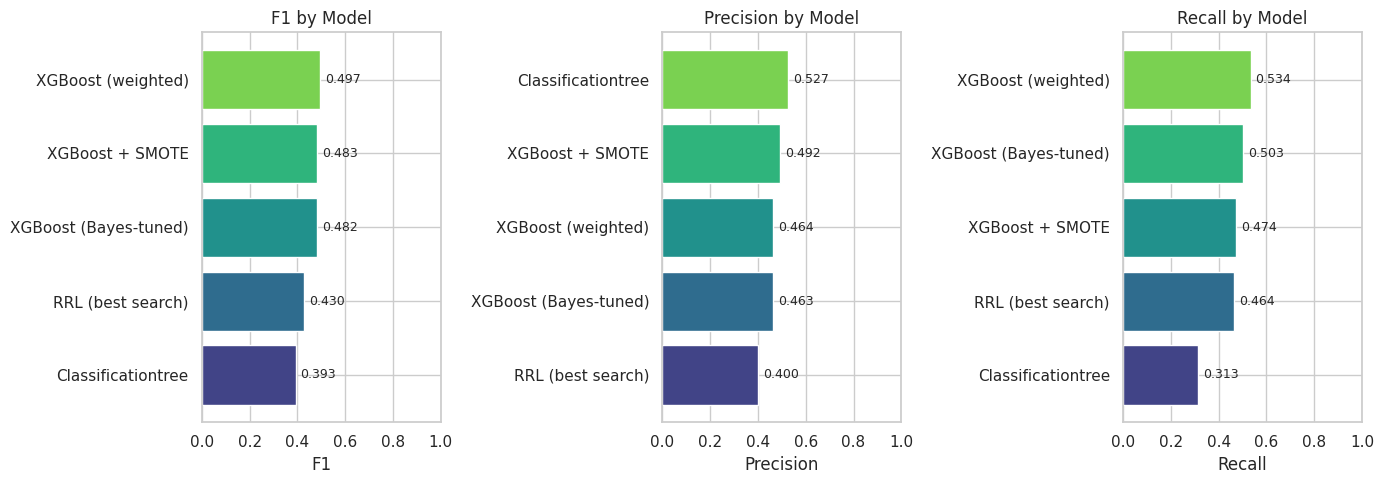

Saved: /home/ermaolaoye/data-mining/outputs/plots/model_comparison.png


In [26]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

metrics_to_plot = ["f1", "precision", "recall"]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))

for ax, metric in zip(axes, metrics_to_plot):
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    bars = ax.barh(sorted_df["name"], sorted_df[metric], color=colors)
    ax.set_xlabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} by Model")
    ax.set_xlim([0, 1])
    
    # Add value labels
    for bar, val in zip(bars, sorted_df[metric]):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                f"{val:.3f}", va="center", fontsize=9)

plt.tight_layout()
comparison_plot_path = PLOTS_DIR / "model_comparison.png"
plt.savefig(comparison_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {comparison_plot_path}")

2025-12-31 13:07:26,460 - [DEBUG] - locator: <matplotlib.ticker.AutoLocator object at 0x7fd8287d1df0>
2025-12-31 13:07:26,546 - [DEBUG] - locator: <matplotlib.ticker.AutoLocator object at 0x7fd828594650>
2025-12-31 13:07:26,597 - [DEBUG] - locator: <matplotlib.ticker.AutoLocator object at 0x7fd828415a90>
2025-12-31 13:07:26,653 - [DEBUG] - locator: <matplotlib.ticker.AutoLocator object at 0x7fd8287ef230>
2025-12-31 13:07:26,717 - [DEBUG] - locator: <matplotlib.ticker.AutoLocator object at 0x7fd82849f200>


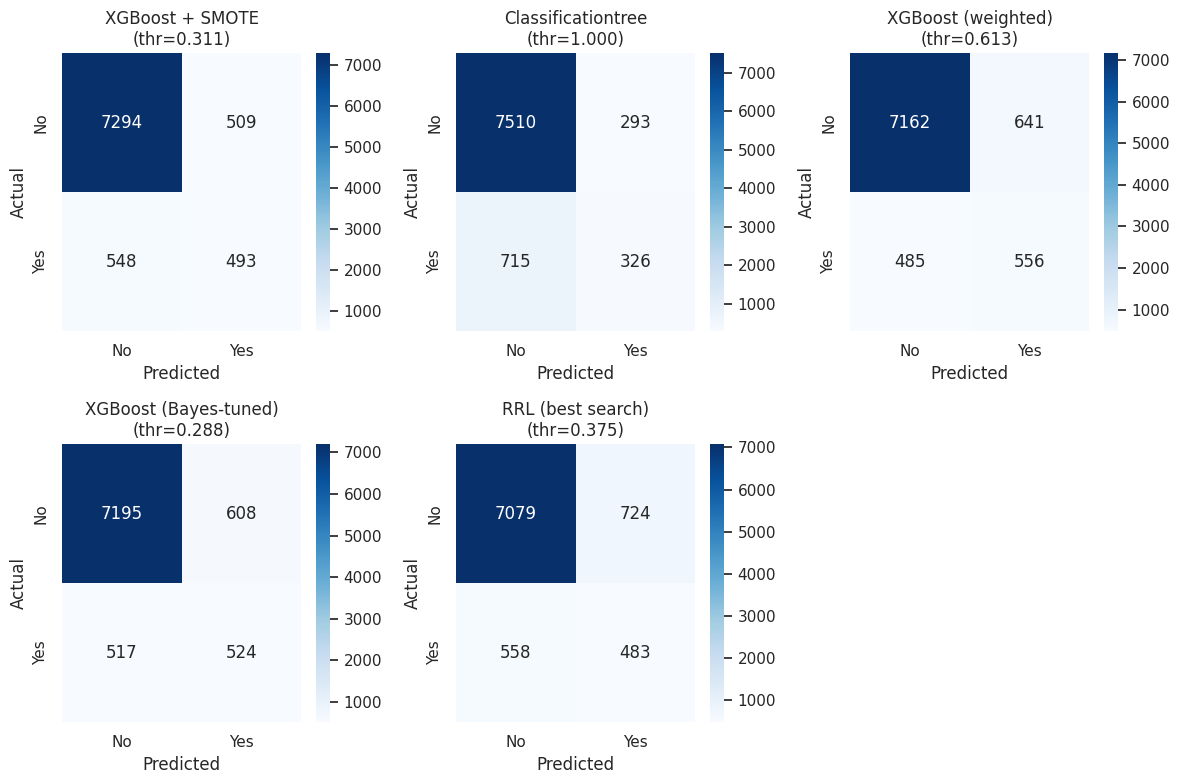

Saved: /home/ermaolaoye/data-mining/outputs/plots/confusion_matrices.png


In [27]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str, ax=None):
    """Plot a confusion matrix with annotations."""
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))
    
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", ax=ax,
        xticklabels=["No", "Yes"], yticklabels=["No", "Yes"]
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    return ax


# Plot confusion matrices for all models in a grid
n_models = len(all_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    title = f"{result['name']}\n(thr={result['threshold']:.3f})"
    plot_confusion_matrix(y_test, result["predictions"], title, ax=axes[idx])

# Hide unused subplots
for idx in range(len(all_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
cm_plot_path = PLOTS_DIR / "confusion_matrices.png"
plt.savefig(cm_plot_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {cm_plot_path}")